In [1]:
from google.colab import drive
drive.mount('/content/drive') #mounting gooogle drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Libraries and Packages used


In [3]:
#importing required libraaries
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#installing scikit-suprise and importing required libraries from surprise package
!pip install scikit-surprise
from surprise import Dataset, Reader, NormalPredictor, SVD, KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data loading and viewing

In [5]:
#creating data frame df from the file called A.txt
df = pd.read_csv('/content/drive/MyDrive/A.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1]) 
#df2 = pd.read_csv('/content/drive/MyDrive/B.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])
#df3 = pd.read_csv('/content/drive/MyDrive/C.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])
#df4 = pd.read_csv('/content/drive/MyDrive/D.txt', header = None, names = ['user_id', 'rating'], usecols = [0,1])

In [9]:
#df=pd.concat([df1,df2,df3,df4])

In [28]:
df 

,user_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [6]:
# creating dataframe using groupby method with rating as index and column gives the count of the rating
df_rating= df.groupby("rating")['rating'].agg(['count']) #agg(['count']) function sums over the elements in the column 'rating' group wise
print(df_rating) #printing the dataframe
print(df_rating['count'].sum()) #printing the total number of reviews

          count
rating         
1.0     1118186
2.0     2439073
3.0     6904181
4.0     8085741
5.0     5506583
24053764


Therefore, the number of reviews of rating 1,2,3,4,5 are 822243, 1965615, 5762698, 6661106, 434403 respectively. The total number of ratings given are 19555695.

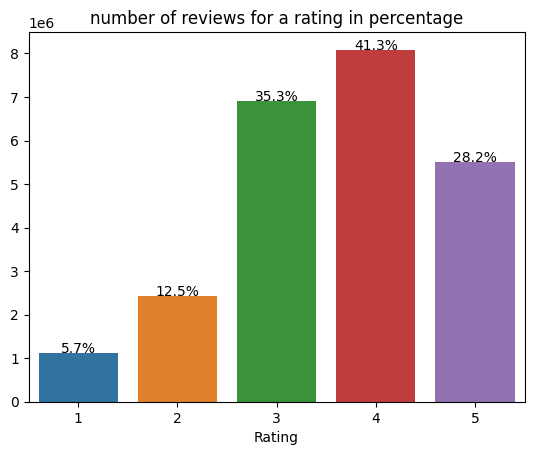

In [7]:
#plotting bar graph where the bar indicates the percentage of number of reviews for a rating
x=[1,2,3,4,5] #list of ratings
y=df_rating['count'].to_list() #obtaining the list of count of ratings
percentage_df= df_rating['count'].apply(lambda x: x*100/19555695) #dataframe with index as rating, column gives the percentage of number of ratings
percentage= percentage_df.tolist() #obtaining the list of percentage of ratings
ax = sns.barplot(x=x, y=y) #plotting bar plot using seaborn with x-axis as ratings and y axis as percentages
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.title("number of reviews for a rating in percentage")
plt.xlabel("Rating")
plt.show() #showing the plot

In [8]:
#creating dataframe df_user using groupby method with user_id as index and number of reviews, average rating as columns
df_user = df.groupby('user_id')['rating'].agg(['count','mean']).dropna()
df_user.rename(columns={"count": "number of reviews", "mean": "average rating"}, inplace=True) #renaming the columns to better names
df_user

,number of reviews,average rating
user_id,,
10,49,3.346939
1000004,1,5.000000
1000027,30,4.300000
1000033,101,3.316832
1000035,20,4.400000
...,...,...
999964,48,4.062500
999972,35,4.057143
999977,14,3.714286


In [37]:
print(df_user['number of reviews'].sum()) #printing the number of ratings
print(len(df_user)) #printing the total number of users who gave atleast one rating

24053764
470758


Total number of reviews given are 24053764

Total no of users are 470758

Text(0.5, 1.0, 'average ratings given by users')

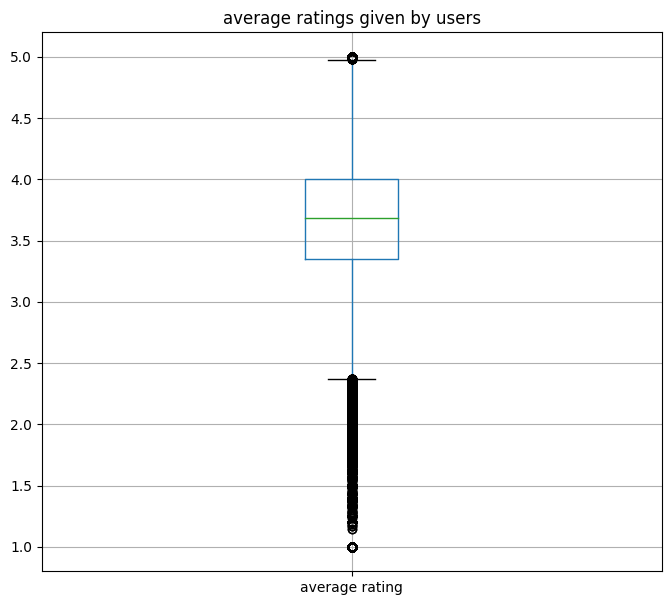

In [9]:
df_user.boxplot(column=['average rating'],figsize=(8,7)) #box plot for the list of 'average rating' given by users. 
plt.title('average ratings given by users')

The average rating combining all the users is around 3.7 

Text(0.5, 1.0, 'number of reviews given by users')

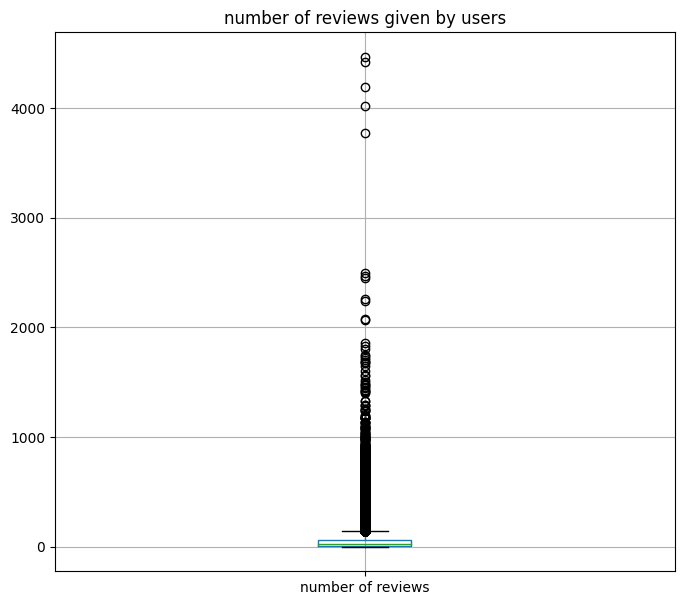

In [10]:
df_user.boxplot(column=['number of reviews'],figsize=(8,7)) #box plot for the list of 'number of reviews' given by users
plt.title("number of reviews given by users")

In [11]:
# Loading the movie titles dataset
df_title = pd.read_csv('/content/drive/MyDrive/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['movie_id', 'year', 'name'],on_bad_lines='skip')
df_title.set_index('movie_id', inplace=True) #setting the index of title dataframe as movie_id
df_title.head() #showing the top few rows of the data frame df_title

,year,name
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [42]:
df_title.shape #shappe of the dataframe df_title

(17434, 2)

The df_title dataframe contains names and year of release of 17434 movies

#Data cleaning and slicing

In [12]:
#creating a dataframe where the column has the value True when the rating is NaN or else False
df_null= pd.DataFrame(df['rating'].isna(), columns=['rating']) 
#getting the list of indexes where the NaN values occured
null_index_list= df_null.index[df_null['rating']==True].tolist()
n=len(null_index_list) # obtaining the legth of the list
df_len= len(df.index)  # obtaining the legth of the dataframe df

In [44]:
print(n) # printing the number of NaN values which are the number of movies

4499


We have ratings for a total of 4499 movies

In [13]:
#Creating a list of movie_id's
movie_id= []
for i in range(n):
  if i<=n-2: #the algorith is same for all indices except for the last index
    m= null_index_list[i+1]-null_index_list[i]-1 #m indicates the number of ratings for a movie
  else:
    m= df_len-1-null_index_list[i] #for the last index to obtain m we use length of dataframe instead of values of succeeding value.
  for j in range(m):
    movie_id.append(i+1) #adding a movie id m number of times


In [46]:
print(len(movie_id))

24053764


In [14]:
#Removing the rows where NaN values occured
df.drop(null_index_list, axis=0, inplace=True)
#adding the column movie_id to the original dataframe df
df['movie_id']= movie_id
df

,user_id,rating,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [15]:
#Creating the dataframe movie_num where the columns indicate number of reviews for a movie_id
movie_num_rev= df['movie_id'].value_counts(ascending=True)
movie_rev= pd.DataFrame({'movie_id':movie_num_rev.index, 'Number of reviews':movie_num_rev.values})
movie_rev

,movie_id,Number of reviews
0,4362,36
1,4338,39
2,3656,42
3,915,43
4,4294,44
...,...,...
4494,571,154832
4495,4432,156183
4496,3860,160454
4497,2152,162597


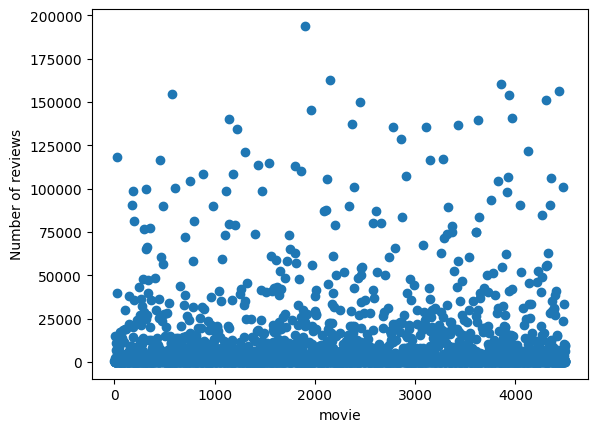

In [16]:
#plotting the scatter plot for number of reviews vs movie_id
x=movie_rev["movie_id"].tolist()
y=movie_rev['Number of reviews'].tolist()
plt.xlabel("movie")
plt.ylabel("Number of reviews")
plt.scatter(x,y)

**Deleting the rows of movies which has less number of reviews**

In [17]:
movie_threshold= round(movie_rev['Number of reviews'].quantile(0.65)) #obtaining a threshold number for number of reviews for a movie_id
popular_movies = movie_rev[movie_rev['Number of reviews'] >= movie_threshold]#selecting the rows for which the number of reviews is greater than threshold
df= df[df['movie_id'].isin(popular_movies['movie_id'].tolist())]# removing the rows in the dataframe df where the movie_id has less number of reviews

In [18]:
movie_threshold #the threshold number

1281

we deleted the rows for which the movie has number of reviews less than 1281

In [19]:
df

,user_id,rating,movie_id
695,1025579,4.0,3
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
...,...,...,...
24056844,267802,4.0,4496
24056845,1559566,3.0,4496
24056846,293198,3.0,4496
24056847,70814,2.0,4496


**Deleting the rows where the users gave less number of reviews**

In [20]:
#Creating the dataframe cust_rev where the columns indicate number of reviews for a user_id
cust_num_rev= df['user_id'].value_counts(ascending=True)
cust_rev= pd.DataFrame({'user_id':cust_num_rev.index, 'Number of reviews':cust_num_rev.values})
cust_rev


,user_id,Number of reviews
0,1017887,1
1,1453951,1
2,339040,1
3,2585657,1
4,263742,1
...,...,...
469685,1664010,1463
469686,2118461,1518
469687,2439493,1534
469688,387418,1563


In [21]:
cust_threshold= round(cust_rev['Number of reviews'].quantile(0.6)) #obtaining a threshold number for the number of reviews
cust_id_threshold = cust_rev[cust_rev['Number of reviews'] >= cust_threshold] #selecting the rows for which number of reviews is greater than threshold
df= df[df['user_id'].isin(cust_id_threshold['user_id'].tolist())] # removing the rows in the dataframe df where the user gave less number of reviews

In [55]:
cust_threshold #threshold of number of reviews given by a user

34

we deleted the rows for which the user gave number of reviews less than 34

In [56]:
df #Dataframe df after eliminating the rows where the user gave less number of reviews

,user_id,rating,movie_id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3
...,...,...,...
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056844,267802,4.0,4496
24056845,1559566,3.0,4496


#collaborative filtering using svd

In [40]:
#Loading the first 200k rows of data using the Dataset from surprise package
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']].iloc[:200000], reader)


In [41]:
#Doing gridsearch to obtain the best paramaters for the svd model
params = {"n_epochs": [5, 10,15,20], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]} #parameter grid for the model svd
grid = GridSearchCV(SVD, params, measures=["rmse", "mae"], cv=5, refit=True) # gridsearch using 5-cross validation with rmse and mae as the measures
grid.fit(data) #fitting the data to the grid
print(grid.best_score) # printing the best rsme and mae values 
print(grid.best_params) # printing the best paramater values

{'rmse': 0.9820853540195358, 'mae': 0.7847152499980672}
{'rmse': {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}}


In [42]:
algo = grid.best_estimator["rmse"] # creating the svd model with best parameter values
algo.fit(data.build_full_trainset()) #fitting the data to the model

In [43]:
#writing function to predict what movies a user might like
df_concat= df_title.copy()
df_concat=df_concat.reset_index()
drop_movie_list= movie_rev[movie_rev['Number of reviews'] < movie_threshold] #The dataframe of rows which has less number of reviews for a movie
df_concat= df_concat[~df_concat['movie_id'].isin(drop_movie_list['movie_id'].tolist())]
#predicting the list of movies which a user_id might like using the predict() method
def pred_movie(userid):
  df_userid= df_concat
  df_userid['estimated_score']=df_concat['movie_id'].apply(lambda x: algo.predict(userid, x).est) #apply th predict method for all the movie_id's 
  df_userid = df_userid.sort_values('estimated_score', ascending=False) #sorting the dataframe in the descending order of the estimated score(rating)
  return df_userid #returning the dataframe of movies the user_id might like

In [44]:
# top 10 movies user 1025579 may like
df_1025579= pred_movie(1025579)
df_1025579.head(10)

,movie_id,year,name,estimated_score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.093118
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,3.846332
51,52,2002.0,The Weather Underground,3.795163
27,28,2002.0,Lilo and Stitch,3.776895
47,48,2001.0,Justice League,3.771738
29,30,2003.0,Something's Gotta Give,3.736248
43,44,1996.0,Spitfire Grill,3.711964
45,46,1964.0,Rudolph the Red-Nosed Reindeer,3.689053
17,18,1994.0,Immortal Beloved,3.687174
55,56,2004.0,Carandiru,3.686253


#Recommending using pearsonR correlation

In [22]:
#Pearson's correlation
#creating a dataframe where movie_id is the index and the columns are the count and mean of ratings of movie_id
df_movie_summary = df.groupby('movie_id')['rating'].agg(['count','mean']) #grouping using movie_id as index and rating as column
df_movie_summary.index = df_movie_summary.index.map(int) #making the indexes integers
df_movie_summary.rename(columns={"count": "number of reviews", "mean": "average rating"}, inplace=True) #renaming the columns to a better name
df_movie_summary

,number of reviews,average rating
movie_id,,
3,1670,3.624551
8,10986,3.154105
16,2579,3.088794
17,4853,2.917165
18,9897,3.773265
...,...,...
4489,1218,3.488506
4490,8531,3.165280
4492,8215,2.651248


In [23]:
#pivoting the dataframe df.The new dataframe has the columns of movie_id' user_id as the index.
#ratings of the movie given by a user_id are the values
df_p = pd.pivot_table(df,values='rating',index='user_id',columns='movie_id')

In [24]:
#writing a function to recommend list of movies for a given movie title and minimum rating based on pearson's correlation
def recommend_movie(title, min_rating):
  movie_id= df_title.index[df_title['name'] == title][0]
  corr_series= df_p.corrwith(df_p[movie_id]) #getting a series of pearsonR values for a given movie
  df_corr= pd.DataFrame(corr_series, columns=['pearsonR'])
  df_corr.index = df_corr.index.map(int)
  df_corr=df_corr.join(df_title)
  df_corr=df_corr.join(df_movie_summary)[['pearsonR','year','name','number of reviews','average rating']] #dataframe of recommended movies
  df_corr.sort_values('pearsonR',ascending=False,inplace=True)
  return df_corr[df_corr['average rating']>=min_rating]

In [25]:
df_title.iloc[1000:1001]

,year,name
movie_id,,
1021,1984.0,Cloak & Dagger


In [26]:
#recommending top 10 movies which are highly correlated with the movie 'Cloak & Dagger' and with average rating greater >= 3
df_cloak_dagger=recommend_movie("Cloak & Dagger",3)
df_cloak_dagger.head(10)

,pearsonR,year,name,number of reviews,average rating
movie_id,,,,,
1021,1.000000,1984.0,Cloak & Dagger,3306,3.722928
375,0.719113,2003.0,Nine Dead Gay Guys,1604,3.034289
2896,0.706698,1980.0,The Last Metro,1293,3.553751
56,0.676311,2004.0,Carandiru,1413,3.615004
4224,0.668453,1996.0,Wish Upon a Star,1139,3.623354
895,0.655033,1975.0,Dersu Uzala,1911,3.904762
2870,0.637518,2000.0,Captain Pantoja and the Special Services,1255,3.346614
4390,0.636531,2000.0,Get Your Stuff,1360,3.071324
707,0.634686,2003.0,The Return,1743,3.497418


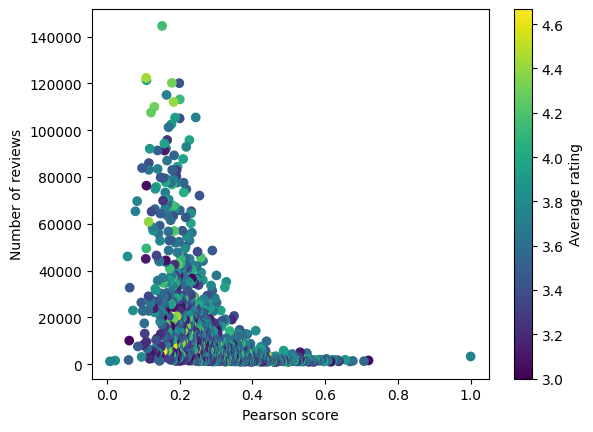

In [27]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(df_cloak_dagger["pearsonR"], df_cloak_dagger["number of reviews"], c=df_cloak_dagger["average rating"])

# Add axis labels
plt.xlabel("Pearson score")
plt.ylabel("Number of reviews")
plt.colorbar(label="Average rating")

# Display the plot
plt.show()

In [28]:
df_title.iloc[2012:2013]

,year,name
movie_id,,
2047,1981.0,Omen III: The Final Conflict


In [29]:
#recommending top 100 movies which are highly correlated with the movie 'Omen III: The Final Conflict' and with average rating >= 2
df_omen3= recommend_movie("Omen III: The Final Conflict",2)
df_omen3.head(10)

,pearsonR,year,name,number of reviews,average rating
movie_id,,,,,
2047,1.000000,1981.0,Omen III: The Final Conflict,2838,3.177237
3102,0.723673,1978.0,Damien: Omen II,4821,3.374819
3808,0.621791,1997.0,Best Men,1252,2.753994
2708,0.609951,1999.0,Candyman 3: Day of the Dead,1775,2.836620
2962,0.606456,1973.0,Coffy,1141,3.308501
2410,0.603720,NaN,NaN,1345,3.203717
2023,0.592653,2000.0,Boys Briefs 2,963,3.208723
718,0.590588,2003.0,44 Minutes,1472,3.301630
1293,0.571846,1996.0,Children of the Corn 4: The Gathering,1927,2.344058


#Analyzing the movie ratings by the year of release date

In [30]:
#Joining the dataframes df_movie_sumary and df_title
#The resulting dataframes has the columns year, name, number of reviews, average rating and movie_id as the index
df_movie_year= df_movie_summary.join(df_title)[['year','name','number of reviews','average rating']] 
# groupby with release year as the index
df_year= df_movie_year.groupby('year')['name','number of reviews','average rating']

<ipython-input-30-0ae87711f605>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_year= df_movie_year.groupby('year')['name','number of reviews','average rating']


In [31]:
df_year.get_group(1999) # getting the group of release year 1999.getting the total movie summary of movies released in the year 1999

,name,number of reviews,average rating
movie_id,,,
45,The Love Letter,2412,2.974710
316,Futurama: Monster Robot Maniac Fun Collection,2364,4.322758
329,Dogma,61503,3.586654
360,Lies,1770,2.358757
414,Girl,1324,2.912387
...,...,...,...
4115,The Simpsons: Bart Wars,3913,4.335548
4145,Law & Order: Special Victims Unit: The First Year,5780,4.157266
4225,Life,8048,3.378603


In [32]:
df_year.get_group(2000) #Getting the group of release year 2000

,name,number of reviews,average rating
movie_id,,,
33,Aqua Teen Hunger Force: Vol. 1,5859,4.146612
113,Bruce Lee: A Warrior's Journey,1183,3.871513
216,Impostor,8108,3.218303
256,Ghost Dog: The Way of the Samurai,11294,3.425890
312,High Fidelity,58459,3.702869
...,...,...,...
4442,Up at the Villa,2233,2.934617
4460,Me Myself I,1868,3.276767
4463,Escaflowne: The Movie,1596,3.564536


In [33]:
#groupby using year as index and total number of reviews for the release year of movies as the column
df_num_rev_year=df_movie_year.groupby('year')['number of reviews'].agg(['count'])
df_num_rev_year

,count
year,
1920.0,1
1925.0,1
1929.0,1
1930.0,2
1931.0,2
...,...
2001.0,106
2002.0,107
2003.0,102


<function matplotlib.pyplot.show(close=None, block=None)>

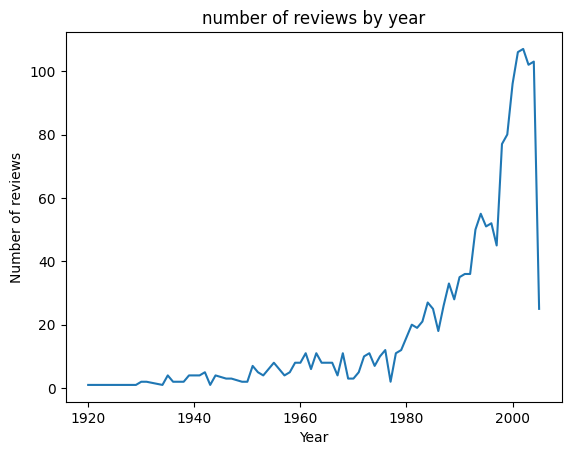

In [34]:
#Plotting the plot for total number of reviews given by users for all the movies of a release year vs the release year
x= df_num_rev_year.index
y= df_num_rev_year['count']
plt.plot(x,y)
plt.xlabel("Year")
plt.ylabel("Number of reviews")
plt.title("number of reviews by year")
plt.show

In [35]:
#groupby using year as index and mean of the average ratings for all the movies released in a release year.
df_avg_rating_year=df_movie_year.groupby('year')['average rating'].agg(['mean'])
df_avg_rating_year

,mean
year,
1920.0,3.397980
1925.0,3.813757
1929.0,3.685673
1930.0,3.861817
1931.0,3.818795
...,...
2001.0,3.356964
2002.0,3.354376
2003.0,3.440670


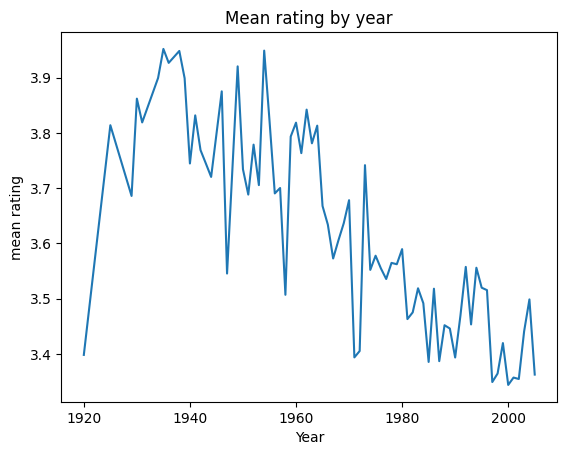

In [36]:
#Plotting the plot for mean rating for all the movies combined of a release year vs the release year.
x= df_avg_rating_year.index
y= df_avg_rating_year['mean']
plt.plot(x,y)
plt.xlabel("Year")
plt.ylabel("mean rating")
plt.title("Mean rating by year")
plt.show()

This is due to the less number of reviews for the old movies.

#Recommending top 'n' movies of a year

In [37]:
# getting top 'n' movies of a year
def top_movie_year(year,num_of_movies):
  df_year_movie= df_year.get_group(year) #getting the group of the release year
  df_year_movie.sort_values('average rating',ascending= False, inplace=True) #sorting the rows in the descending order of average rating of a movie_id
  print(df_year_movie.head(num_of_movies)) #printing the top 'n' rows, n=num_of_movies

In [38]:
#getting top 5 movies of the year 2000
top_movie_year(2000,5)

                                                       name  \
movie_id                                                      
4238                                              Inu-Yasha   
2162                                          CSI: Season 1   
1915      Law & Order: Special Victims Unit: The Second ...   
2548                                Gilmore Girls: Season 1   
3668                                     Farscape: Season 2   

          number of reviews  average rating  
movie_id                                     
4238                   1213        4.487222  
2162                  14328        4.382747  
1915                   1680        4.338095  
2548                   7204        4.268462  
3668                   4238        4.228410  


<ipython-input-37-4a009f3e48b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_movie.sort_values('average rating',ascending= False, inplace=True) #sorting the rows in the descending order of average rating of a movie_id


In [39]:
#getting top 5 movies of the year 2005
top_movie_year(2005,5)

                            name  number of reviews  average rating
movie_id                                                           
3864               Batman Begins              42810        4.243985
4033             Alias: Season 4               3738        4.231140
1994        The L Word: Season 2               1932        4.136128
1073                Coach Carter              40212        4.043171
760       Pooh's Heffalump Movie               6785        3.809580


<ipython-input-37-4a009f3e48b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_movie.sort_values('average rating',ascending= False, inplace=True) #sorting the rows in the descending order of average rating of a movie_id
